In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from darts import TimeSeries
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts.dataprocessing import Pipeline
from darts import concatenate

In [2]:
data = pd.read_csv(r'C:\Users\Vajapeve\OneDrive - Carrier Corporation\IAQ study\Edison project\Code_received\08_project\08_project\Data\infinity_wallcontrol_power_data.csv')

In [3]:
data.head()

timestamp   oat  zone_rt  zone_htsp  zone_clsp  \
0  2022-10-01 15:50:00+00:00  60.0     64.0       60.0       65.0   
1  2022-10-01 15:55:00+00:00  60.0     64.0       60.0       65.0   
2  2022-10-01 16:00:00+00:00  60.0     64.0       60.0       65.0   
3  2022-10-01 16:05:00+00:00  60.0     64.0       60.0       65.0   
4  2022-10-01 16:10:00+00:00  60.0     64.0       60.0       65.0   

   vfd_ac_line_power  vfd_ac_line_power_raw zone_currentActivity mode  \
0                0.0                    NaN                  NaN  NaN   
1                0.0                    0.0                 Home  Off   
2                0.0                    0.0                 Home  Off   
3                0.0                    0.0                 Home  Off   
4                0.0                    NaN                 Home  Off   

  zone_conditioningStatus  
0                     NaN  
1                    idle  
2                    idle  
3                    idle  
4                    idle

In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [5]:
data['timestamp'] = data['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [6]:
#plt.figure(figsize=(15,8))
fig = px.scatter(data, x=data['timestamp'], y=data['vfd_ac_line_power'])
fig.show()

In [7]:
data_new = data[['timestamp','oat','zone_rt','vfd_ac_line_power']]

In [8]:
data_new

timestamp   oat  zone_rt  vfd_ac_line_power
0      2022-10-01 15:50:00  60.0     64.0           0.000000
1      2022-10-01 15:55:00  60.0     64.0           0.000000
2      2022-10-01 16:00:00  60.0     64.0           0.000000
3      2022-10-01 16:05:00  60.0     64.0           0.000000
4      2022-10-01 16:10:00  60.0     64.0           0.000000
...                    ...   ...      ...                ...
37191  2023-03-08 23:20:00  35.0     66.0         255.362391
37192  2023-03-08 23:25:00  35.0     66.0         243.283031
37193  2023-03-08 23:30:00  34.0     66.0         230.762009
37194  2023-03-08 23:35:00  33.5     66.0         217.799324
37195  2023-03-08 23:40:00  33.0     66.0         204.394977

[37196 rows x 4 columns]

In [9]:
data_new.isna().sum()

timestamp               0
oat                  2105
zone_rt              2105
vfd_ac_line_power       0
dtype: int64

In [10]:
data_new = data_new.set_index('timestamp')

In [11]:
data_new

oat  zone_rt  vfd_ac_line_power
timestamp                                            
2022-10-01 15:50:00  60.0     64.0           0.000000
2022-10-01 15:55:00  60.0     64.0           0.000000
2022-10-01 16:00:00  60.0     64.0           0.000000
2022-10-01 16:05:00  60.0     64.0           0.000000
2022-10-01 16:10:00  60.0     64.0           0.000000
...                   ...      ...                ...
2023-03-08 23:20:00  35.0     66.0         255.362391
2023-03-08 23:25:00  35.0     66.0         243.283031
2023-03-08 23:30:00  34.0     66.0         230.762009
2023-03-08 23:35:00  33.5     66.0         217.799324
2023-03-08 23:40:00  33.0     66.0         204.394977

[37196 rows x 3 columns]

In [12]:
data_new.index = pd.to_datetime(data_new.index)

In [13]:
data_new = data_new.resample('H').mean()

In [14]:
data_new_series = TimeSeries.from_dataframe(data_new,fill_missing_dates=True, freq='60min')

In [15]:
from darts.dataprocessing.transformers import MissingValuesFiller
transformer = MissingValuesFiller()
data_new_series = transformer.transform(data_new_series)

<AxesSubplot:xlabel='timestamp'>

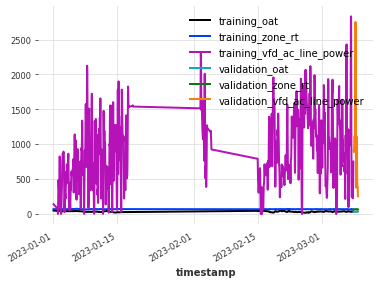

In [16]:
train, val = data_new_series.split_before(pd.Timestamp("20230308"))
valex, train = train.split_after(pd.Timestamp("20230101"))
train.plot(label="training")
val.plot(label="validation")

In [17]:
len(train)

1583

In [18]:
# Catboost model
from darts.models import CatBoostModel
validation = val
target = train['vfd_ac_line_power']
past_cov = concatenate([train['zone_rt'],train['oat']],axis=1)
cat_model = CatBoostModel(
    lags=12,
    lags_past_covariates=12,
    output_chunk_length=24,
    random_state= 42,
)
cat_model.fit(target, past_covariates=past_cov)
cat_pred = cat_model.predict(len(val))
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],cat_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

MAPE:42.50183810148678


In [57]:
#Random forest implementation
from darts.models import RandomForest
target = train['vfd_ac_line_power']
validation = val
past_cov = concatenate([train['zone_rt'],train['oat']],axis=1)
rf_model = RandomForest(
    lags=24,
    lags_past_covariates=24,
    output_chunk_length=24,
    n_estimators=80,
    max_depth=2,
    criterion="absolute_error",
    bootstrap=True,
    min_samples_split=6,
    random_state=42,
)
rf_model.fit(target,past_covariates=past_cov)
rf_pred = rf_model.predict(len(val))
# start_date = pd.to_datetime('2023-03-07')
# end_date = pd.to_datetime('2023-03-08')
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],rf_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

MAPE:62.597733315464055


In [19]:
#Dlinear model
from darts.models import DLinearModel
validation = val
target = train['vfd_ac_line_power']
past_cov = concatenate([train['zone_rt'],train['oat']],axis=1)
dlinear_model = DLinearModel(
    input_chunk_length=18,
    output_chunk_length=24,
    n_epochs=200,
    random_state=42,
)
dlinear_model.fit(target, past_covariates=past_cov)
dlinear_pred = dlinear_model.predict(len(val))
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],dlinear_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 1.3 K 
5 | linear_trend    | Linear           | 1.3 K 
-----------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.011     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

MAPE:46.35708486280865


In [21]:
#FFT model
from darts.models import FFT
validation = val
target = train['vfd_ac_line_power']
fft_model = FFT(
    nr_freqs_to_keep=20,
    trend= "poly",
    trend_poly_degree=2,
)
fft_model.fit(target)
fft_pred = fft_model.predict(len(val))
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],fft_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

MAPE:34.3076081944582


In [22]:
#Kalman forecast model
from darts.models import KalmanForecaster
validation = val
target = train['vfd_ac_line_power']
kalman_model = KalmanForecaster(dim_x=12)
kalman_model.fit(target)
kalman_pred = kalman_model.predict(len(val))
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],kalman_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

MAPE:45.69113620871533


In [23]:
#light gbm model
from darts.models import LightGBMModel
validation = val
target = train['vfd_ac_line_power']
past_cov = concatenate([train['zone_rt'],train['oat']],axis=1)
lightgbm_model = LightGBMModel(
    lags=12,
    lags_past_covariates=12,
    output_chunk_length=24,
    verbose=-1,
    random_state=42,
)
lightgbm_model.fit(target, past_covariates=past_cov)
lightgbm_pred = lightgbm_model.predict(len(val))
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],lightgbm_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

MAPE:46.6370285928667


In [24]:
#Nhits model
from darts.models import NHiTSModel
validation = val
target = train['vfd_ac_line_power']
past_cov = concatenate([train['zone_rt'],train['oat']],axis=1)
hits_model = NHiTSModel(
    input_chunk_length=18,
    output_chunk_length=24,
    num_blocks=2,
    n_epochs=200,
    random_state=42,
)
hits_model.fit(target, past_covariates=past_cov)
hits_pred = hits_model.predict(len(val))
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],hits_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.8 M 
---------------------------------------------------
1.8 M     Trainable params
27.7 K    Non-trainable params
1.8 M     Total params
7.366     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

MAPE:137.0738713829115


In [25]:
#Nlinear model
from darts.models import NLinearModel
validation = val
target = train['vfd_ac_line_power']
past_cov = concatenate([train['zone_rt'],train['oat']],axis=1)
nlinear_model = NLinearModel(
    input_chunk_length=18,
    output_chunk_length=24,
    n_epochs=200,
    random_state=42,
)
nlinear_model.fit(target, past_covariates=past_cov)
nlinear_pred = nlinear_model.predict(len(val))
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],nlinear_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 1.3 K 
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

MAPE:46.61287492622957


In [29]:
#TCN model
from darts.models import TCNModel
validation = val
target = train['vfd_ac_line_power']
past_cov = concatenate([train['zone_rt'],train['oat']],axis=1)
tcn_model = TCNModel(
    input_chunk_length=25,
    output_chunk_length=24,
    random_state = 42,
    n_epochs=200,
)
tcn_model.fit(target, past_covariates=past_cov)
tcn_pred = tcn_model.predict(len(val))
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],tcn_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 164   
----------------------------------------------------
164       Trainable params
0         Non-trainable params
164       Total params
0.001     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

MAPE:45.035543238300704


In [30]:
#Tide model
from darts.models import TiDEModel
validation = val
target = train['vfd_ac_line_power']
past_cov = concatenate([train['zone_rt'],train['oat']],axis=1)
tide_model = TiDEModel(
    input_chunk_length=18,
    output_chunk_length=24,
    random_state = 42,
    n_epochs=200,
)
tide_model.fit(target, past_covariates=past_cov)
tide_pred = tide_model.predict(len(val))
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],tide_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

number of `past_covariates` features is <= `temporal_width_past`, leading to feature expansion.number of covariates: 2, `temporal_width_past=4`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params
---------------------------------------------------------
0 | criterion           | MSELoss          | 0     
1 | train_metrics       | MetricCollection | 0     
2 | val_metrics         | MetricCollection | 0     
3 | past_cov_projection | _ResidualBlock   | 912   
4 | encoders            | Sequential       | 39.8 K
5 | decoders            | Sequential       | 115 K 
6 | temporal_decoder    | _ResidualBlock   | 594   
7 | lookback_skip       | Linear           | 456   
---------------------------------------------------------
157 K     Trainable params
0         Non-trainable params
157 K     Total params
0.629     Total estimated model params siz

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

MAPE:44.38892364274166


In [60]:
#Transformer model
from darts.models import TransformerModel
validation = val
target = train['vfd_ac_line_power']
past_cov = concatenate([train['zone_rt'],train['oat']],axis=1)
trans_model = TransformerModel(
    input_chunk_length=18,
    output_chunk_length=24,
    n_epochs=200,
    random_state = 42,
)
trans_model.fit(target, past_covariates=past_cov)
trans_pred = trans_model.predict(len(val))
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],trans_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

C:\Users\Vajapeve\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 256   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 1.6 K 
--------------------------------------------------

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

MAPE:68.75566476764034


In [63]:
#XGB model
from darts.models import XGBModel
validation = val
target = train['vfd_ac_line_power']
past_cov = concatenate([train['zone_rt'],train['oat']],axis=1)
xgb_model = XGBModel(
    lags=24,
    lags_past_covariates=24,
    output_chunk_length=24,
    random_state = 42,
)
xgb_model.fit(target, past_covariates=past_cov)
xgb_pred = xgb_model.predict(len(val))
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],xgb_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

MAPE:40.75321191832429


In [31]:
#TFT model
from darts.models import TFTModel
validation = val
target = train['vfd_ac_line_power']
past_cov = concatenate([train['zone_rt'],train['oat']],axis=1)
tft_model = TFTModel(
    input_chunk_length=24,
    output_chunk_length=24,
    n_epochs=200,
    random_state=42,
    add_relative_index=True
)
tft_model.fit(target, past_covariates=past_cov)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 528   
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K 
8  | static_cont

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.


TFTModel(hidden_size=16, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=24, n_epochs=200, random_state=42)

In [32]:
tft_pred = tft_model.predict(len(val))
from darts.metrics import mape
error = mape(validation['vfd_ac_line_power'],tft_pred['vfd_ac_line_power'])
print(f'MAPE:{error}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

MAPE:94.18325536030947


In [64]:
#Conversion into forecast into pa
data_new_all = data_new_series.pd_dataframe()
cat_boost = cat_pred.pd_dataframe()
kalman = kalman_pred.pd_dataframe()
hits = hits_pred.pd_dataframe()
lightgbm = lightgbm_pred.pd_dataframe()
nlinear = nlinear_pred.pd_dataframe()
dlinear = dlinear_pred.pd_dataframe()
fft = fft_pred.pd_dataframe()
tcn = tcn_pred.pd_dataframe()
tide = tide_pred.pd_dataframe()
tft = tft_pred.pd_dataframe()
random_forest = rf_pred.pd_dataframe()
transformer_model = trans_pred.pd_dataframe()
xgb = xgb_pred.pd_dataframe()

In [65]:
# Plotly visualization
fig = go.Figure()

# Plot train series
fig.add_trace(go.Scatter(x=data_new_all.index, y=data_new_all['vfd_ac_line_power'],
                         mode='lines', name='all_data'))

# #Plot test series

fig.add_trace(go.Scatter(x=cat_boost.index, y=cat_boost['vfd_ac_line_power'],
                         mode='lines', name='cat_boost'))
fig.add_trace(go.Scatter(x=kalman.index, y=kalman['vfd_ac_line_power'],
                         mode='lines', name='Kalman_model'))
fig.add_trace(go.Scatter(x=hits.index, y=hits['vfd_ac_line_power'],
                         mode='lines', name='nhits_model'))
fig.add_trace(go.Scatter(x=lightgbm.index, y=lightgbm['vfd_ac_line_power'],
                         mode='lines', name='lightgbm_model'))
fig.add_trace(go.Scatter(x=nlinear.index, y=nlinear['vfd_ac_line_power'],
                          mode='lines', name='nlinear_model'))
fig.add_trace(go.Scatter(x=dlinear.index, y=dlinear['vfd_ac_line_power'],
                          mode='lines', name='dlinear_model'))
fig.add_trace(go.Scatter(x=fft.index, y=fft['vfd_ac_line_power'],
                          mode='lines', name='fft_model'))
fig.add_trace(go.Scatter(x=tcn.index, y=tcn['vfd_ac_line_power'],
                          mode='lines', name='tcn_model'))
fig.add_trace(go.Scatter(x=tide.index, y=tide['vfd_ac_line_power'],
                          mode='lines', name='tide_model'))
fig.add_trace(go.Scatter(x=tft.index, y=tft['vfd_ac_line_power'],
                          mode='lines', name='tft_model'))
fig.add_trace(go.Scatter(x=random_forest.index, y=random_forest['vfd_ac_line_power'],
                          mode='lines', name='random_forest'))
fig.add_trace(go.Scatter(x=transformer_model.index, y=transformer_model['vfd_ac_line_power'],
                          mode='lines', name='transformer_model'))
fig.add_trace(go.Scatter(x=xgb.index, y=xgb['vfd_ac_line_power'],
                          mode='lines', name='XGB_model'))
# Layout adjustments
fig.update_layout(title='Time Series Forecasting',
                  xaxis_title='Time',
                  yaxis_title='Vfd_ac_line_power')

# Show plot
fig.show()

In [66]:
fig.write_html("other_models_comparison_4thdjan.html")